In [11]:
import os
import random
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import pandas as pd
from model import FinalModel
import math

# === 設定路徑 ===
H5_PATH = "C:/Users/User/py_project/gaze-tracking/data/mpiifacegaze_preprocessed/data.h5"
IMG_ROOT = "C:/Users/User/py_project/gaze-tracking/data/mpiifacegaze_preprocessed"
CKPT_PATH = "C:/Users/User/py_project/gaze-tracking/saved_models/p00/p00_best-v46.ckpt"
NOT_ON_SCREEN_CSV = "C:/Users/User/py_project/gaze-tracking/data/mpiifacegaze_preprocessed/not_on_screen.csv"

# === 設定隨機抽樣數量 ===
NUM_SAMPLES = 500



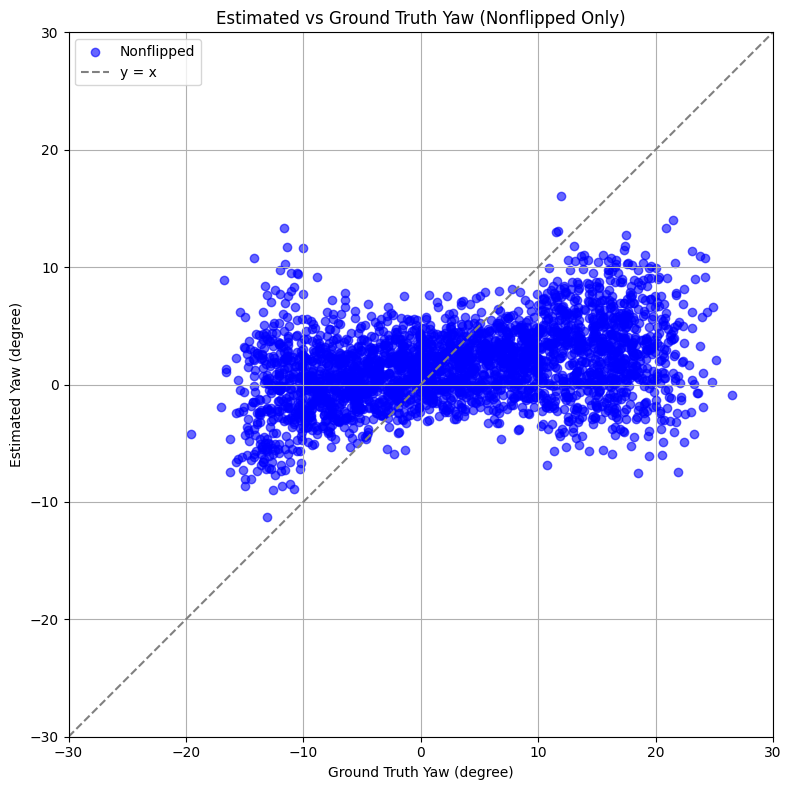

In [12]:
# === 載入 not_on_screen 檔案並去掉副檔名 ===
not_on_screen_df = pd.read_csv(NOT_ON_SCREEN_CSV)
not_on_screen_set = set([name[:-4] for name in not_on_screen_df['file_name']])

# === 載入 H5 檔案 ===
with h5py.File(H5_PATH, 'r') as f:
    file_names_all = [name.decode('utf-8') for name in f['file_name_base'][:]]
    gt_yaw_all = f['gaze_yaw'][:]

# === 僅處理 p06 的樣本 ===
valid_indices = [i for i, name in enumerate(file_names_all) if name.startswith('p00/') and name not in not_on_screen_set]


# === 載入模型 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FinalModel()
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt['state_dict'])
model = model.to(device)
model.eval()

# === 圖片預處理 ===
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

gt_yaws = []
est_yaws = []

with torch.no_grad():
    for idx in valid_indices:
        file_base = file_names_all[idx]
        person_id = int(file_base.split("/")[0][1:])

        # 讀圖
        def load_img(suffix):
            path = os.path.join(IMG_ROOT, file_base + suffix)
            img = Image.open(path).convert('RGB')
            return preprocess(img)

        try:
            full_face = load_img("-full_face.png")
            left_eye = load_img("-left_eye.png")
            right_eye = load_img("-right_eye.png")
        except FileNotFoundError:
            continue  # 若圖檔不存在則略過此樣本

        input_face = full_face.unsqueeze(0).to(device)
        input_left = left_eye.unsqueeze(0).to(device)
        input_right = right_eye.unsqueeze(0).to(device)
        input_id = torch.tensor([person_id], dtype=torch.long).to(device)

       # 推論（radian → degree）
        output = model(input_id, input_face, input_right, input_left)
        raw_est_deg = math.degrees(output[0][1].item())   # 原始模型輸出（degree）
        gt_deg = math.degrees(gt_yaw_all[idx])            # GT 轉 degree
        
        if gt_deg < -10:
            corrected_est = raw_est_deg * 1.5
        elif gt_deg > 10:
            corrected_est = raw_est_deg * 1.5
        else:
            corrected_est = raw_est_deg

        
                
        # 儲存資料
        gt_yaws.append(gt_deg)
        est_yaws.append(corrected_est)

# === 畫圖 ===
plt.figure(figsize=(8, 8))
plt.scatter(gt_yaws, est_yaws, color='blue', label='Nonflipped', alpha=0.6)
plt.plot([-30, 30], [-30, 30], color='gray', linestyle='--', label='y = x')
plt.xlabel('Ground Truth Yaw (degree)')
plt.ylabel('Estimated Yaw (degree)')
plt.title('Estimated vs Ground Truth Yaw (Nonflipped Only)')
plt.legend()
plt.grid(True)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()
